# Earth matter effect in neutrino oscillations

## Earth density profile

We define the neutrino path through Earth, before reaching a detector, in terms of the Nadir angle. The Nadir angle $\theta_{\mathrm{n}}$ is the angle between the neutrino direction and the direction of the horizon. That way, if $\theta_{\mathrm{n}} = 0$, the neutrino is comming right from the horizon, tangent to Earth and intercepting the planet at the detector site, so no Earth matter effect is observed for $\theta_{\mathrm{n}} \leq 0$. On the other side, if $\theta_{\mathrm{n}} = \pi/2$, the neutrino's direction is straight down, meaning that the path crosses the entire planet. If $\pi \geq \theta_{\mathrm{n}} \geq \pi/2$, the symmetry of Earth allows the description of the problem exactly as the case $\pi/2 \geq \theta_{\mathrm{n}} \geq 0$.

Our primary goal is to express the Earth's density radial profile $\rho(r)$, in terms of the neutrino path $x$ through the planet. That is, we want $\rho(x)$. In order to obtain such function, we need to express $r(x)$.

For any given angle $\theta_{\mathrm{n}}$, the total length $L$ of the neutrino path through Earth may be written, using the cosines law, as

\begin{align}
    L = R_{\mathrm{Earth}} \sqrt{2[1 - \cos(2 \theta_{\mathrm{n}})]}
\end{align}

Therefore $0 \leq x \leq L$, for any $\theta_{\mathrm{n}} \geq 0$. For any point $x_i$ in the trajectory $x$, the radial distance $r$ from $x_i$ to Earth's center is also written using the cosines law

\begin{align}
    r^2 = x_i^2 + R_{\mathrm{Earth}}^2 - 2 x_i R_{\mathrm{Earth}} \cos \left( \frac{\pi}{2} - \theta_{\mathrm{n}} \right)
\end{align}

As expected, if $\theta_{\mathrm{n}} = \pi/2$, the cosine term is $1$ and $r = R_{\mathrm{Earth}} - x_i$. We must only compute $\rho(r)$ in the PREM model, for each $x_i$ in the neutrino trajectory, given in terms of $\theta_{\mathrm{n}}$.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import scipy.stats as st
from tqdm import tqdm
from numba import njit
from scipy.integrate import simps
from scipy.interpolate import interp1d


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
# https://en.wikipedia.org/wiki/Neutrino_oscillation
theta_12 = 33.447*2*np.pi/360
theta_23 = 45*2*np.pi/360
theta_13 = 8.878*2*np.pi/360
delta_cp = 0#195*2*np.pi/360

c_12 = np.cos(theta_12)
c_13 = np.cos(theta_13)
c_23 = np.cos(theta_23)
s_12 = np.sin(theta_12)
s_13 = np.sin(theta_13)
s_23 = np.sin(theta_23)

U = np.array([[c_12*c_13, s_12*c_13, s_13*np.exp(-1j*delta_cp)],
             [-s_12*c_23-c_12*s_23*s_13*np.exp(1j*delta_cp), c_12*c_23-s_12*s_23*s_13*np.exp(1j*delta_cp), s_23*c_13],
             [s_12*s_23-c_12*c_23*s_13*np.exp(1j*delta_cp), -c_12*s_23-s_12*c_23*s_13*np.exp(1j*delta_cp), c_23*c_13]])

#delta_m = np.array([2.44e-3, 7.53e-5, 2.44e-3])
delta_m = {'m_10': 7.53e-2, 'm_20': 2.44, 'm_21': 2.44,
           'm_01': 7.53e-2, 'm_02': 2.44, 'm_12': 2.44} #eV²

$$ V_{CC} = \pm \sqrt{2} G_F N_e \approx \pm 7.6 \times Y_e \times 10^{-14} \left( \frac{\rho}{\mathrm{g}/\mathrm{cm}^3} \right) \mathrm{eV} $$

We assume that Earth is neutral and isoscalar, which implies $Y_e = 0.5$. Positive sign for neutrinos and negative sign for antineutrinos ([Upadhyay, A. K. 2022](https://arxiv.org/abs/2211.08688)).

In [6]:
R_earth = 6371 # Km
R_core = 3486 # Km
Avog = 6.022e23
c = 2.99792458e8 #m/s
G_F = 1.16632e-23 #eV^-2
g_to_eV = c**2/1000 * 6.242e18
cm3_to_eV3 = (0.197e9*1e-15*100)**3

In [4]:
data_ea = np.loadtxt('Data/Earth_density_profile_kg_per_m3.txt', delimiter=';', skiprows=4)
data_ea_mol_e = np.loadtxt('Data/Earth_density_profile_mols_electron_per_cm3.txt', delimiter=';',
                           skiprows=4)
r_data_earth = data_ea[:,0] #km
rho_earth = data_ea[:,1]*1e3/1e6# * Na #cm^-3 #* cm3_to_eV3 #eV^3
r_data_earth_mols = data_ea_mol_e[:,0]
ne_earth = data_ea_mol_e[:,1]

In [7]:
print(f'Average density of Earths core: {np.mean(data_ea[:np.where(data_ea[:,0] >= R_core)[0][0],1]*1e3/1e6):.2f} g/cm³')
print(f'Average density of Earths mantle: {np.mean(data_ea[np.where(data_ea[:,0] >= R_core)[0][0]:,1]*1e3/1e6):.2f} g/cm³')

print(f'\nAverage electron density of Earths core: {np.mean(data_ea_mol_e[:np.where(data_ea_mol_e[:,0] >= R_core)[0][0],1]):.2f} moles of e⁻/cm³')
print(f'Average electorn density of Earths mantle: {np.mean(data_ea_mol_e[np.where(data_ea_mol_e[:,0] >= R_core)[0][0]:,1]):.2f} moles of e⁻/cm³')

Average density of Earths core: 10.83 g/cm³
Average density of Earths mantle: 4.22 g/cm³

Average electron density of Earths core: 5.20 moles of e⁻/cm³
Average electorn density of Earths mantle: 2.20 moles of e⁻/cm³


In [8]:
N_e_m = 2.2 # moles e⁻ cm^-3
N_e_c = 5.2 # moles e⁻ cm^-3

In [9]:
f_density = interp1d(r_data_earth, rho_earth, fill_value = 'extrapolate')

In [10]:
# Computing the neutrino path and the Earth density ρ(r) for each location x_i on the path
def nu_path(nadir):
    L = R_earth*np.sqrt(2*(1-np.cos(2*nadir)))
    path = np.linspace(0, L, 10000)
    rho_path = []
    for i in range(len(path)):
        r = np.sqrt(R_earth**2 + path[i]**2 - 2*R_earth*path[i]*np.cos(np.pi/2 - nadir))
        rho_path.append(f_density(r))
    rho_path = np.array(rho_path)
    return path, rho_path

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


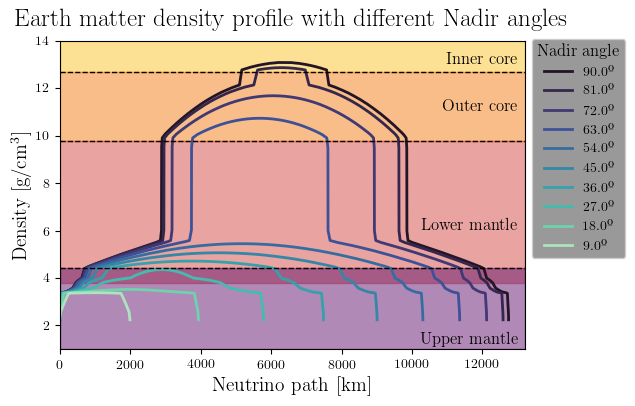

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
for i in tqdm(range(10)):
    nadir = np.pi/2 - i*np.pi/20
    plt.plot(nu_path(nadir)[0], nu_path(nadir)[1], color = sns.color_palette('mako', 10)[i],
            label = f'{(nadir*180/np.pi):.1f}º', lw = 2)

plt.xlabel('Neutrino path [km]', fontsize = 14)
plt.ylabel(r'Density [g/cm$^3$]', fontsize = 14)
plt.xlim(0, 13200)
plt.ylim(1, 14)
lgd = plt.legend(fontsize = 10, title = 'Nadir angle', bbox_to_anchor = (1,1.03),
                facecolor = 'grey')
lgd.get_title().set_fontsize(12)
plt.title('Earth matter density profile with different Nadir angles', fontsize = 18,
         pad = 10)
plt.axhline(12.7, lw = 1, ls = '--', color = 'black')
plt.text(13000, 13, 'Inner core', fontsize = 12, ha = 'right')
plt.fill_between([0, 13200], 12.7, 14, color = sns.color_palette('inferno', 6)[5], alpha = 0.5)
plt.axhline(9.8, lw = 1, ls = '--', color = 'black')
plt.text(13000, 11, 'Outer core', fontsize = 12, ha = 'right')
plt.fill_between([0, 13200], 9.8, 12.7, color = sns.color_palette('inferno', 6)[4], alpha = 0.5)
plt.axhline(4.4, lw = 1, ls = '--', color = 'black')
plt.text(13000, 6, 'Lower mantle', fontsize = 12, ha = 'right')
plt.fill_between([0, 13200], 3.8, 9.8, color = sns.color_palette('inferno', 6)[3], alpha = 0.5)
plt.text(13000, 1.2, 'Upper mantle', fontsize = 12, ha = 'right')
plt.fill_between([0, 13200], 1, 4.4, color = sns.color_palette('inferno', 6)[1], alpha = 0.5)
# plt.savefig('Plots/Earth_matter_density_profile_nadir_angle.png', dpi = 300, bbox_inches = 'tight')
# plt.savefig('Plots/Earth_matter_density_profile_nadir_angle.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [12]:
dens_prof = np.zeros((100, 10000))

for i in tqdm(range(100)):
    nadir = np.pi/2 - i*np.pi/200
    L_max = 2*R_earth
    L = R_earth*np.sqrt(2*(1-np.cos(2*nadir)))
    path = np.arange(0, L, L_max/10000)
    for j in range(len(path)):
        r = np.sqrt(R_earth**2 + path[j]**2 - 2*R_earth*path[j]*np.cos(np.pi/2 - nadir))
        dens_prof[i,j] = f_density(r)

100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


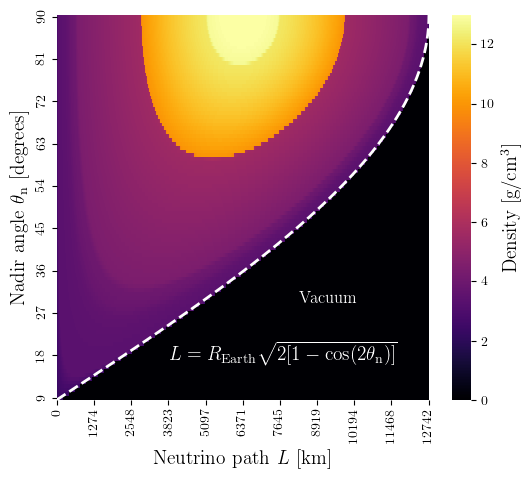

In [13]:
fig, ax = plt.subplots(figsize=(6,5))
htmp = sns.heatmap(dens_prof, cmap = 'inferno', ax = ax, vmin = 0, vmax = 13,
                   cbar_kws={'label': r'Density [g/cm$^3$]'})
# plt.scatter(np.array(inner_core)[:,1], np.array(inner_core)[:,0])
htmp.figure.axes[-1].yaxis.label.set_size(14)
plt.yticks([11*i + 0.5 for i in range(10)], labels = [90 - 9*i for i in range(10)])
plt.ylabel(r'Nadir angle $\theta_{\mathrm{n}}$ [degrees]', fontsize = 14)
plt.xticks([999*i for i in range(11)],
           labels = [int(np.round(0.1*i*L_max, 0)) for i in range(11)])
plt.xlabel('Neutrino path $L$ [km]', fontsize = 14)
plt.text(6500, 75, 'Vacuum', fontsize = 12, color = 'white')
y = np.linspace(0, 100, 1000)
plt.plot(5000*np.sqrt(2*(1-np.cos(2*y/63.6619))), -y+100,
        color = 'white', lw = 2, ls = '--')
plt.text(3000, 90, r'$L = R_{\mathrm{Earth}} \displaystyle \sqrt{2[1 - \cos(2\theta_{\mathrm{n}})]}$',
         fontsize = 14, color = 'white')
# plt.savefig('Plots/Neutrino_path_density_profile_nadir_angle.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
lat = 36.4257
lon = 137.3103